Currently I'm thinking that while we're studying the various types of sources we would save a version of this notebook which focuses on each fault. 

In [36]:
%matplotlib inline
import os
import json
import codecs
import numpy as np
import pickle

import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.seismicity.declusterer as decluster
import hmtk.plotting.seismicity.catalogue_plots as cp

from copy import deepcopy
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

from hmtk.seismicity.occurrence.weichert import Weichert
from hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from hmtk.seismicity.occurrence.kijko_smit import KijkoSmit

# Catalogue and sources 
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser

from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

from hmtk.plotting.faults.geology_mfd_plot import plot_recurrence_models
from openquake.hazardlib.scalerel.wc1994 import WC1994

In [2]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisDangerousSources11_300km.xml"

catalogue_filename = '../seismicity/Marmaris-catalogue1_homogenised_cleaned.csv'

In [3]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30546
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


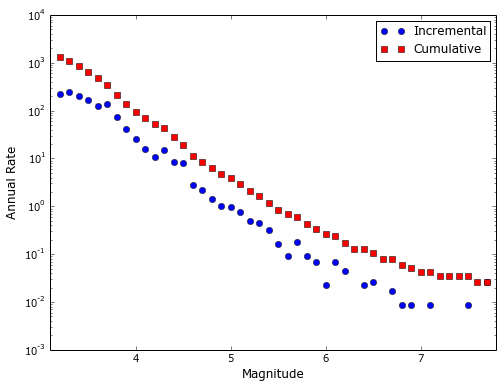

Completeness table guess
[[ 2004.      3.2]
 [ 1992.      4.3]
 [ 1972.      4.5]
 [ 1900.      6.5]]


In [4]:
completeness_table_guess = np.array([[2004, 3.2],
                                     [1992, 4.3], 
                                     [1972, 4.5], 
                                     [1900, 6.5]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_guess, 0.1)
print 'Completeness table guess'
print completeness_table_guess

In [5]:
# identify clusters
declusterer = decluster.dec_gardner_knopoff.GardnerKnopoffType1()
decluster_config = {
    'time_distance_window': decluster.distance_time_windows.UhrhammerWindow(), 
    'fs_time_prop': 1.0}
cluster_index, cluster_flag = declusterer.decluster(catalogue, decluster_config)

# purge catalogue
declustered = deepcopy(catalogue)
mainshock_flag = cluster_flag == 0 
declustered.purge_catalogue(mainshock_flag)

In [6]:
# Map configuration
span = 1 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

In [7]:
# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

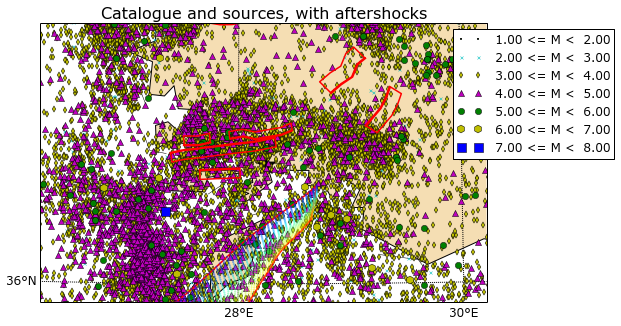

Number of events:  30546


In [8]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, with aftershocks')
my_map.add_catalogue(catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(catalogue.data['magnitude'])

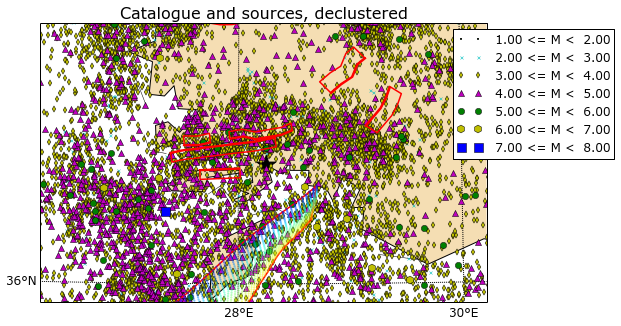

Number of events:  19049


In [9]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, declustered')
my_map.add_catalogue(declustered, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(declustered.data['magnitude'])

In [10]:
selector = CatalogueSelector(declustered, create_copy=True)

In [11]:
for source in source_model.sources:
    if isinstance(source, src.area_source.mtkAreaSource): 
        source.select_catalogue(selector)
        print 'Area source %s, name %s, # of events %8.0f' % (
            source.id, source.name, source.catalogue.get_number_events())
        #subcatalogue_area = selector.    

In [51]:
r_km = 3*np.ones_like(source_model.sources)
r_km[-1] = 30
for i, source in enumerate(source_model.sources):
    if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
        source.select_catalogue(selector, r_km[i])
    elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
        source.select_catalogue(selector, r_km[i]) 
        
    print '%s: %s, %d events wihin %g km' % (
        source.id, source.name, source.catalogue.get_number_events(), r_km[i])

TRCS394: Datca Horst North Boundary 1, 28 events wihin 2 km
TRCS391: Gokova Oren Fault Zone 1, 101 events wihin 2 km
TRCS331: Buyuk Menderes Graben North Boundary 2, 108 events wihin 2 km
TRCS271: Golgelidag Horst West Boundary - Tavas, 20 events wihin 2 km
TRCS322: Gediz Graben South Boundary, 65 events wihin 2 km
TRCS393: Gokova Oren Fault Zone 3, 39 events wihin 2 km
TRCS390: Aksu Thrust, 277 events wihin 2 km
TRCS268: Golgelidag Horst East Boundary - Akalan, 35 events wihin 2 km
TRCS913: Ula-Oren, 277 events wihin 2 km
TRCS330: Buyuk Menderes Graben North Boundary 1, 195 events wihin 2 km
HELL001: Hellenic Arc, 4235 events wihin 30 km


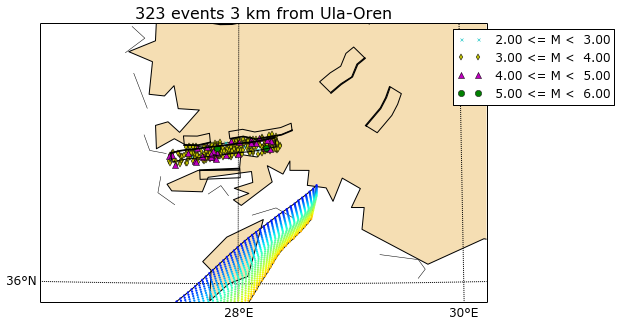

In [81]:
fault_id = 'TRCS913'
r_km = 3
source = [source for source in source_model.sources if source.id == fault_id][0]
if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
    source.select_catalogue(selector, r_km)
elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
    source.select_catalogue(selector, r_km) 
#for i, source in enumerate(source_model.sources):
n_events = source.catalogue.get_number_events()
# if n_events < 5: continue
basemap = HMTKBaseMap(
    map_config, '%d events %d km from %s' % (n_events, r_km, source.name))
basemap.add_catalogue(source.catalogue, overlay=True)
basemap.add_source_model(source_model, area_border='k-')

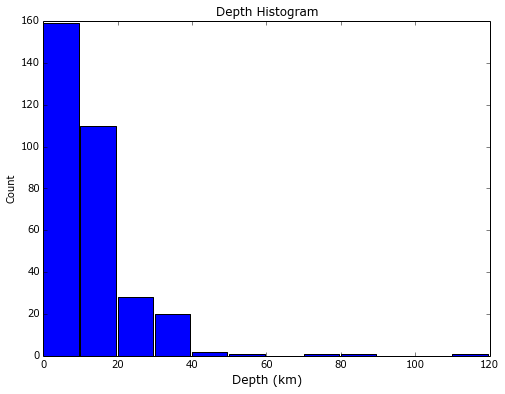

In [82]:
cp.plot_depth_histogram(source.catalogue, 10)

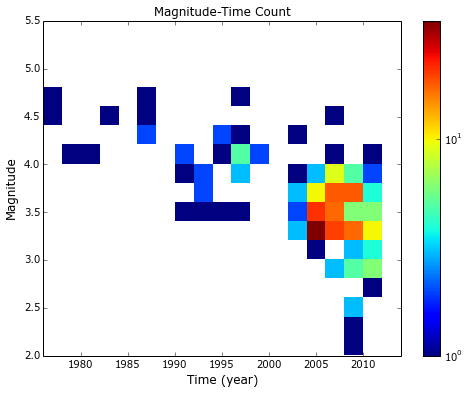

In [83]:
cp.plot_magnitude_time_density(source.catalogue, 0.2, 2)

In [84]:
# Set up the configuration parameterss
complete_config = {'magnitude_bin': 1.0, 'time_bin': 5.0, 
               'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(
    source.catalogue, complete_config)

completeness_table = completeness_table[~np.isnan(completeness_table).any(axis=1)]

# Print the completeness table
print 'Completeness table using Stepp method (1971)'
print np.round(completeness_table)


# Setting configuration for the completeness plot
#plot_stepp_1972.create_stepp_plot(completeness_algorithm,'output_data/Stepp_prueba.png' )


Completeness table using Stepp method (1971)
[[  2.00300000e+03   2.00000000e+00]
 [  1.99900000e+03   3.00000000e+00]
 [  1.98500000e+03   4.00000000e+00]]


In [85]:
completeness_table_guess = np.array([[2004, 3.2],
                                     [1992, 4.3], 
                                     [1972, 4.5], 
                                     [1900, 6.5]])

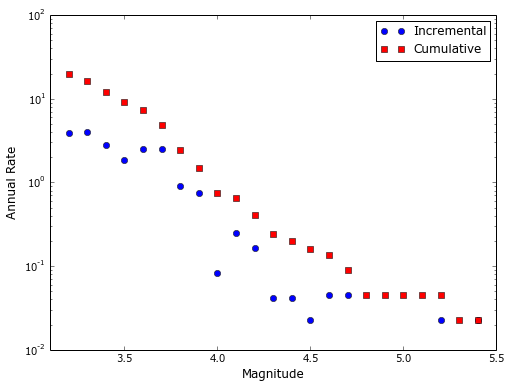

In [86]:

cp.plot_observed_recurrence(source.catalogue, completeness_table_guess, 0.1)

In [87]:
'''
Implements the maximum likelihood estimator of Weichert (1980)
'''

# Set up the configuration parameters
weichert_config = {'magnitude_interval': 0.2, 'bvalue': 1., 'itstab': 1E-5, 'maxiter': 1000}

recurrence = Weichert()

bval, sigmab, rate, sigmarate = recurrence.calculate(source.catalogue, weichert_config, completeness = completeness_table_guess)

print '\n'
print 'Weichert: ok'
print 'bval =', bval, 'sigmab =', sigmab, 'rate =', rate, 'sigmarate =', sigmarate
print '\n'



Weichert: ok
bval = 1.19488371932 sigmab = 0.0538562683058 rate = 5.04488636044 sigmarate = 0.0249074975101




In [88]:

# Set up fault parameters
slip = 1.75  # Slip rate in mm/yr

# Area = along-strike length (km) * down-dip with (km)
area = source.geometry.get_area()

# Rake = 0.
if source.rake >= 180:
    rake = source.rake - 360
else:
    rake = source.rake

# Magnitude Scaling Relation
msr = WC1994()


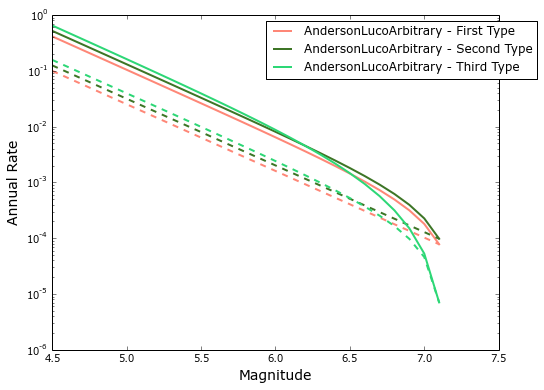

In [91]:
#Magnitude Frequency Distribution Example


anderson_luco_config1 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'First',
                         'Model_Weight': 1.0,  # Weight is a required key - normally weights should sum to 1.0 - current example is simply illustrative! 
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [bval, sigmab]}
anderson_luco_config2 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Second',
                         'Model_Weight': 1.0,
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [bval, sigmab]}
anderson_luco_config3 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Third',
                         'Model_Weight': 1.0,   
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [bval, sigmab]}
# Create a list of the configurations
anderson_luco_arb = [anderson_luco_config1, anderson_luco_config2, anderson_luco_config3]

# View the corresponding magnitude recurrence model
plot_recurrence_models(anderson_luco_arb, area, slip, msr, rake, msr_sigma=0.0)

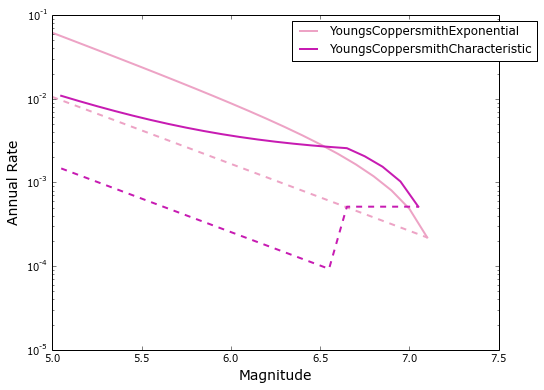

In [90]:
exponential = {'Model_Name': 'YoungsCoppersmithExponential',
               'MFD_spacing': 0.1,
               'Maximum_Magnitude': None,
               'Maximum_Magnitude_Uncertainty': None,
               'Minimum_Magnitude': 5.0,
               'Model_Weight': 1.0,
               'b_value': [0.8, 0.1]}

hybrid = {'Model_Name': 'YoungsCoppersmithCharacteristic',
          'MFD_spacing': 0.1,
          'Maximum_Magnitude': None,
          'Maximum_Magnitude_Uncertainty': None,
          'Minimum_Magnitude': 5.0,
          'Model_Weight': 1.0,
          'b_value': [0.8, 0.1],
          'delta_m': None}

youngs_coppersmith = [exponential, hybrid]

# View the corresponding magnitude recurrence model
plot_recurrence_models(youngs_coppersmith, area, slip, msr, rake, msr_sigma=0.0)